In [1]:
import os
import re
import string
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

BATCH_SIZE = 32
EPOCHS = 5
MAX_LEN = 75
EMBEDDING = 50

def isEven(n):
    return n % 2 == 0

def filter_string(s):
    return ''.join(filter(lambda x: x in string.printable, s))

def split_words(s):
    return re.sub("[^\w]", " ",  s).split()

def transform_sentences(sentences):
    # Convert each sentence from list of Token to list of word_index
    X = [[word2idx[w[0]] for w in s] for s in sentences]
    # Padding each sentence to have the same lenght
    X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

    # Convert Tag/Label to tag_index
    y = [[tag2idx[w[1]] for w in s] for s in sentences]
    # Padding each sentence to have the same lenght
    y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])

    # One-Hot encode
    y = [to_categorical(i, num_classes=n_tags+1) for i in y]  # n_tags+1(PAD)
    return X, y


Using TensorFlow backend.


In [2]:
leis_dir = 'leis_vetadas/'
leis = []
leis_split = []
words = []
for fname in os.listdir(leis_dir):
    with open(leis_dir+fname, "r", encoding="utf-8") as f:
        r = f.read()
        leis.append(r)
        leis_split.append(r.split('**VETO**'))
        file_words = text_to_word_sequence(r)
        # file_words = split_words(r)
        words += file_words


In [3]:
#X_tmp = []
#y_tmp = []
sentences = []

for l in leis_split:
    i = 0
    sx = []
    sy = []
    for s in l:
        i += 1
        w = text_to_word_sequence(s)
        sx += w
        if isEven(i):
            sy += ["b-veto"]
            sy += ["veto" for _ in range(len(w)-2)]
            sy += ["e-veto"]
        else:
            sy += ['b-ok']
            sy += ["ok" for _ in range(len(w)-2)]
            sy += ['e-ok']
    sentences.append([[sx[a],sy[a]] for a in range(len(w))])

# sentences = list(zip(X_tmp, y_tmp))

In [18]:
vocab = list(set(words))
n_words = len(vocab)

tags = ["ok",'b-ok','e-ok',"veto",'b-veto','e-veto']
n_tags = len(tags)

word2idx = {w: i + 2 for i, w in enumerate(vocab)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

# Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}

# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}

print("The word paulo is identified by the index: {}".format(word2idx["paulo"]))
print("ok {}".format(tag2idx["ok"]))

X, y = transform_sentences(sentences)

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape

print('Raw Sample: ', ' '.join([w[0] for w in sentences[0]]))
print('Raw Label: ', ' '.join([w[1] for w in sentences[0]]))
print('After processing, sample:', X[0])
print('After processing, labels:', y[0])
# print(idx2tag)

The word paulo is identified by the index: 1587
ok 1
Raw Sample:  projeto de lei nº 283 de 2012 institui a semana de conscientização prevenção e combate a verminose no estado de são paulo e dá outras providências a assembleia legislativa do estado de são paulo decreta artigo 1º fica a secretaria estadual de saúde autorizada instituir a semana de conscientização prevenção e combate a verminose no estado de são paulo parágrafo único a semana de conscientização prevenção e combate a verminose no estado são paulo mencionada no caput deste artigo deverá obrigatoriamente abranger a primeira semana de abril artigo 2º os objetivos da semana de conscientização prevenção e combate a verminose no estado de são paulo i promover a conscientização e orientar com regras básicas de cuidados de higiene domiciliar e pessoal para evitar a contaminação através de profissionais qualificados ii criar a oportunidade de integração de órgãos e entidades públicos e privados em ações conjuntas em benefício da co

In [5]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
#from keras.layers import CRF

# Model definition
input = Input(shape=(MAX_LEN,))
model = Embedding(input_dim=n_words+2, output_dim=EMBEDDING, # n_words + 2 (PAD & UNK)
                  input_length=MAX_LEN, mask_zero=True)(input)  # default: 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.15))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags+1)  # CRF layer, n_tags+1(PAD)
out = crf(model)  # output

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()

model.load_weights("model/alesp-2019-05-24.hdf5")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/lib64/python3.7/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/lib64/python3.7/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 50)            228000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 100)           40400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 7)             420       
Total params: 273,870
Trainable params: 273,870
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(X_tr, np.array(y_tr), batch_size=BATCH_SIZE, epochs=600,
                    validation_split=0.2, verbose=2)

Train on 16 samples, validate on 4 samples
Epoch 1/600
 - 0s - loss: 0.6256 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0749 - val_crf_viterbi_accuracy: 1.0000
Epoch 2/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0781 - val_crf_viterbi_accuracy: 0.9957
Epoch 3/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0786 - val_crf_viterbi_accuracy: 0.9957
Epoch 4/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0787 - val_crf_viterbi_accuracy: 0.9957
Epoch 5/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0786 - val_crf_viterbi_accuracy: 0.9957
Epoch 6/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0786 - val_crf_viterbi_accuracy: 0.9957
Epoch 7/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0785 - val_crf_viterbi_accuracy: 0.9957
Epoch 8/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0783 - val_crf_viterbi_accuracy: 0.9957
Epoch 9/600
 

Epoch 70/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0774 - val_crf_viterbi_accuracy: 1.0000
Epoch 71/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0774 - val_crf_viterbi_accuracy: 1.0000
Epoch 72/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0776 - val_crf_viterbi_accuracy: 1.0000
Epoch 73/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0770 - val_crf_viterbi_accuracy: 1.0000
Epoch 74/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0768 - val_crf_viterbi_accuracy: 1.0000
Epoch 75/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0764 - val_crf_viterbi_accuracy: 1.0000
Epoch 76/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0760 - val_crf_viterbi_accuracy: 1.0000
Epoch 77/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0757 - val_crf_viterbi_accuracy: 1.0000
Epoch 78/600
 - 0s - loss: 0.6255 - crf_viterbi_

Epoch 139/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0761 - val_crf_viterbi_accuracy: 1.0000
Epoch 140/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0759 - val_crf_viterbi_accuracy: 1.0000
Epoch 141/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0757 - val_crf_viterbi_accuracy: 1.0000
Epoch 142/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0757 - val_crf_viterbi_accuracy: 1.0000
Epoch 143/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0758 - val_crf_viterbi_accuracy: 1.0000
Epoch 144/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0764 - val_crf_viterbi_accuracy: 1.0000
Epoch 145/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0763 - val_crf_viterbi_accuracy: 1.0000
Epoch 146/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0758 - val_crf_viterbi_accuracy: 1.0000
Epoch 147/600
 - 0s - loss: 0.6255 - crf

Epoch 208/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0830 - val_crf_viterbi_accuracy: 0.9914
Epoch 209/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0828 - val_crf_viterbi_accuracy: 0.9914
Epoch 210/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0803 - val_crf_viterbi_accuracy: 0.9957
Epoch 211/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0794 - val_crf_viterbi_accuracy: 0.9957
Epoch 212/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0787 - val_crf_viterbi_accuracy: 0.9957
Epoch 213/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0773 - val_crf_viterbi_accuracy: 1.0000
Epoch 214/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0777 - val_crf_viterbi_accuracy: 1.0000
Epoch 215/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0765 - val_crf_viterbi_accuracy: 1.0000
Epoch 216/600
 - 0s - loss: 0.6255 - crf

Epoch 277/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0763 - val_crf_viterbi_accuracy: 1.0000
Epoch 278/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0765 - val_crf_viterbi_accuracy: 1.0000
Epoch 279/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0764 - val_crf_viterbi_accuracy: 1.0000
Epoch 280/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0781 - val_crf_viterbi_accuracy: 1.0000
Epoch 281/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0797 - val_crf_viterbi_accuracy: 0.9957
Epoch 282/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0799 - val_crf_viterbi_accuracy: 0.9957
Epoch 283/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0805 - val_crf_viterbi_accuracy: 0.9957
Epoch 284/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0807 - val_crf_viterbi_accuracy: 0.9957
Epoch 285/600
 - 0s - loss: 0.6255 - crf

Epoch 346/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0938 - val_crf_viterbi_accuracy: 0.9828
Epoch 347/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0912 - val_crf_viterbi_accuracy: 0.9828
Epoch 348/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0866 - val_crf_viterbi_accuracy: 0.9914
Epoch 349/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0833 - val_crf_viterbi_accuracy: 0.9957
Epoch 350/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0864 - val_crf_viterbi_accuracy: 0.9957
Epoch 351/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0923 - val_crf_viterbi_accuracy: 0.9828
Epoch 352/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0950 - val_crf_viterbi_accuracy: 0.9828
Epoch 353/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0954 - val_crf_viterbi_accuracy: 0.9828
Epoch 354/600
 - 0s - loss: 0.6255 - crf

Epoch 415/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0986 - val_crf_viterbi_accuracy: 0.9828
Epoch 416/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.1026 - val_crf_viterbi_accuracy: 0.9785
Epoch 417/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.0986 - val_crf_viterbi_accuracy: 0.9828
Epoch 418/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.1078 - val_crf_viterbi_accuracy: 0.9785
Epoch 419/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.1069 - val_crf_viterbi_accuracy: 0.9785
Epoch 420/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.1145 - val_crf_viterbi_accuracy: 0.9785
Epoch 421/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.1078 - val_crf_viterbi_accuracy: 0.9785
Epoch 422/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.1078 - val_crf_viterbi_accuracy: 0.9785
Epoch 423/600
 - 0s - loss: 0.6255 - crf

Epoch 484/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.1501 - val_crf_viterbi_accuracy: 0.9700
Epoch 485/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.1732 - val_crf_viterbi_accuracy: 0.9657
Epoch 486/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.1711 - val_crf_viterbi_accuracy: 0.9657
Epoch 487/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.1653 - val_crf_viterbi_accuracy: 0.9657
Epoch 488/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.1646 - val_crf_viterbi_accuracy: 0.9657
Epoch 489/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.1618 - val_crf_viterbi_accuracy: 0.9700
Epoch 490/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.1586 - val_crf_viterbi_accuracy: 0.9700
Epoch 491/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.1545 - val_crf_viterbi_accuracy: 0.9700
Epoch 492/600
 - 0s - loss: 0.6255 - crf

Epoch 553/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.1744 - val_crf_viterbi_accuracy: 0.9614
Epoch 554/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.1882 - val_crf_viterbi_accuracy: 0.9485
Epoch 555/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.1828 - val_crf_viterbi_accuracy: 0.9571
Epoch 556/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.1870 - val_crf_viterbi_accuracy: 0.9485
Epoch 557/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.1871 - val_crf_viterbi_accuracy: 0.9485
Epoch 558/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.1815 - val_crf_viterbi_accuracy: 0.9571
Epoch 559/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.1820 - val_crf_viterbi_accuracy: 0.9571
Epoch 560/600
 - 0s - loss: 0.6255 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.1701 - val_crf_viterbi_accuracy: 0.9614
Epoch 561/600
 - 0s - loss: 0.6255 - crf

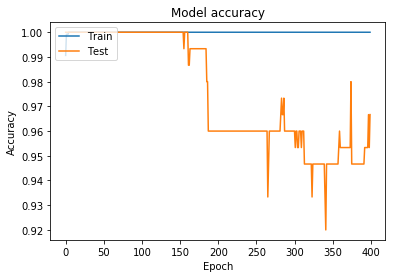

In [13]:
plt.plot(history.history['crf_viterbi_accuracy'])
plt.plot(history.history['val_crf_viterbi_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

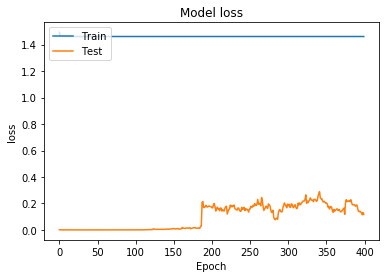

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [15]:
# Eval
pred_cat = model.predict(X_te)
pred = np.argmax(pred_cat, axis=-1)
y_te_true = np.argmax(y_te, -1)

from sklearn_crfsuite.metrics import flat_classification_report

# Convert the index to tag
pred_tag = [[idx2tag[i] for i in row] for row in pred]
y_te_true_tag = [[idx2tag[i] for i in row] for row in y_te_true] 

report = flat_classification_report(y_pred=pred_tag, y_true=y_te_true_tag)

print(report)

              precision    recall  f1-score   support

        b-ok       1.00      1.00      1.00         1
        e-ok       1.00      1.00      1.00         1
      e-veto       1.00      1.00      1.00         1
          ok       1.00      1.00      1.00       153
        veto       1.00      1.00      1.00        69

   micro avg       1.00      1.00      1.00       225
   macro avg       1.00      1.00      1.00       225
weighted avg       1.00      1.00      1.00       225



In [20]:
from ipywidgets import interact_manual
from ipywidgets import widgets

import sys
import math
import re
import string

# Custom Tokenizer
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()
    
def get_prediction(sentence):
    test_sentence = tokenize(sentence) # Tokenization
    s_len = len(test_sentence)
    t_sentences = []
    #print('len(test_sentence)', s_len)
    # Preprocessing
    for step in range(math.ceil(s_len / MAX_LEN)):
        sentence1 = test_sentence[75*step:75*(step+1)]
        #print("*************************************")
        #print(sentence1)
        #print("*************************************")
        t_sentences.append(pad_sequences(sequences=[[word2idx.get(w, 0) for w in sentence1]],
                           padding="post", value=word2idx["PAD"], maxlen=MAX_LEN)[0])

    p = model.predict(np.array(t_sentences))
    p = np.array([np.argmax(p1, axis=-1) for p1 in p])
    # Visualization

    for w, pred in zip(test_sentence, np.ndarray.flatten(p)):
        #print("{:15}: {:5}".format(w, idx2tag[pred]))
        if idx2tag[pred] in ['b-veto', 'veto', 'e-veto']:
            sys.stdout.write("\x1b[31m"+w+"\x1b[0m ")
        else:
            sys.stdout.write(w+' ')

interact_manual(get_prediction, sentence=widgets.Textarea(placeholder='Type your sentence here'));

interactive(children=(Textarea(value='', description='sentence', placeholder='Type your sentence here'), Butto…